# Laboratorio no calificado: Ingeniería de rasgos con imágenes

En este cuaderno opcional, verá cómo preparar características con un conjunto de datos de imágenes, particularmente [CIFAR-10](https://www.tensorflow.org/datasets/catalog/cifar10). En su mayor parte, seguirá los mismos pasos, pero deberá agregar funciones de análisis sintáctico en su módulo de transformación para leer y convertir los datos con éxito. Al igual que en los cuadernos anteriores, sólo repasaremos brevemente las primeras etapas del pipeline para que puedas centrarte en el componente Transform.

Comencemos.

## Imports

In [1]:
import os
import pprint
import tempfile
import urllib

import absl
import tensorflow as tf
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

from tfx import v1 as tfx

from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.types import Channel

from google.protobuf.json_format import MessageToDict

print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.6.0
TFX version: 1.3.0


## Set up pipeline paths

In [2]:
# Location of the pipeline metadata store
_pipeline_root = './pipeline/'

# Data files directory
_data_root = './data/cifar10'

# Path to the training data
_data_filepath = os.path.join(_data_root, 'train.tfrecord')

## Download example data

Descargaremos la división de entrenamiento del conjunto de datos CIFAR-10 y la guardaremos en el `ruta del archivo de datos`. Tenga en cuenta que esto ya está en formato TFRecord por lo que no necesitaremos convertirlo cuando usemos `ExampleGen` más tarde.

In [3]:
# Create data folder for the images
!mkdir -p {_data_root}

# URL of the hosted dataset
DATA_PATH = 'https://raw.githubusercontent.com/tensorflow/tfx/v0.21.4/tfx/examples/cifar10/data/train.tfrecord'

# Download the dataset and save locally
urllib.request.urlretrieve(DATA_PATH, _data_filepath)

('./data/cifar10/train.tfrecord', <http.client.HTTPMessage at 0x7f232c3fc7c0>)

## Create the InteractiveContext

In [4]:
# Initialize the InteractiveContext
context = InteractiveContext(pipeline_root=_pipeline_root)

## Run TFX components interactively



### ExampleGen

Como se ha mencionado anteriormente, el conjunto de datos ya está en formato TFRecord, por lo que, a diferencia de los anteriores laboratorios TFX, no es necesario convertirlo cuando ingerimos los datos. Simplemente se puede importar con [ImportExampleGen](https://www.tensorflow.org/tfx/api_docs/python/tfx/components/ImportExampleGen) y aquí está la sintaxis y los módulos para ello.

In [5]:
# Ingest the data through ExampleGen
example_gen = tfx.components.ImportExampleGen(input_base=_data_root)

# Run the component
context.run(example_gen)

ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 1
        type_id: 14
        uri: "./pipeline/ImportExampleGen/examples/1"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "file_format"
          value {
            string_value: "tfrecords_gzip"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:67847507,xor_checksum:1668794781,sum_checksum:1668794781"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            int_value: 0
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.3.0"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

As usual, this component produces two artifacts, training examples and evaluation examples:

In [7]:
# Print split names and URI
artifact = example_gen.outputs['examples'].get()[0]
print(artifact.split_names, artifact.uri)

["train", "eval"] ./pipeline/ImportExampleGen/examples/1


También puede echar un vistazo a los tres primeros ejemplos de entrenamiento ingeridos utilizando el método `tf.io.parse_single_example()` del módulo [tf.io](https://www.tensorflow.org/api_docs/python/tf/io). Vea cómo está configurado en la celda de abajo.

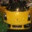

'Class ID: 1'


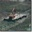

'Class ID: 8'


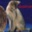

'Class ID: 3'


In [8]:
import IPython.display as display

# Obtener el URI del artefacto de salida que representa los ejemplos de entrenamiento, que es un directorio
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'Split-train')

# Obtener la lista de archivos de este directorio (todos los archivos TFRecord comprimidos)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Crear un `TFRecordDataset` para leer estos archivos
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Descripción por ejemplo
image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

# Función de análisis de imágenes
def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

# Asignar el analizador al conjunto de datos
parsed_image_dataset = dataset.map(_parse_image_function)

# Mostrar las tres primeras imágenes
for features in parsed_image_dataset.take(3):
    image_raw = features['image_raw'].numpy()
    display.display(display.Image(data=image_raw))
    pprint.pprint('Class ID: {}'.format(features['label'].numpy()))

### StatisticsGen

A continuación, generará las estadísticas para poder inferir un esquema en el siguiente paso. También puede ver la visualización de las estadísticas. Como es de esperar con CIFAR-10, hay una columna para la imagen y otra columna para la etiqueta numérica.

In [9]:
# Run StatisticsGen
statistics_gen = tfx.components.StatisticsGen(
    examples=example_gen.outputs['examples'])

context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 2
        type_id: 16
        uri: "./pipeline/StatisticsGen/statistics/2"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.3.0"
          }
        }
        state: LIVE
        , artifact_type: id: 16
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [12]:
# Visualize the results
context.show(statistics_gen.outputs['statistics'])

### SchemaGen

Aquí, usted pasa las estadísticas para generar el esquema. Para la versión de TFX que está utilizando, tendrá que establecer explícitamente `infer_feature_shape=True` para que los componentes TFX posteriores (por ejemplo, Transform) analicen la entrada como un `Tensor` y no `SparseTensor`. Si no se establece, tendrá problemas de compatibilidad más tarde cuando ejecute la transformación.

In [13]:
# Run SchemaGen
schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)
context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 3
        type_id: 18
        uri: "./pipeline/SchemaGen/schema/3"
        custom_properties {
          key: "name"
          value {
            string_value: "schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "SchemaGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.3.0"
          }
        }
        state: LIVE
        , artifact_type: id: 18
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [15]:
# Visualize the results
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'image_raw',BYTES,required,,-
'label',INT,required,,-


### ExampleValidator

El `ExampleValidator` no es necesario, pero puedes ejecutarlo para asegurarte de que no hay anomalías.

In [16]:
# Run ExampleValidator
example_validator = tfx.components.ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])
context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: Channel(
            type_name: ExampleAnomalies
            artifacts: [Artifact(artifact: id: 4
        type_id: 20
        uri: "./pipeline/ExampleValidator/anomalies/4"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "anomalies"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "ExampleValidator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.3.0"
          }
        }
        state: LIVE
        , artifact_type: id: 20
        name: "ExampleAnomalies"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [17]:
# Visualize the results. There should be no anomalies.
context.show(example_validator.outputs['anomalies'])

### Transform

Para transformar con éxito la imagen en bruto, es necesario analizar el formato de bytes actual y convertirlo en un tensor. Para ello, puede utilizar la función [tf.image.decode_image()](https://www.tensorflow.org/api_docs/python/tf/io/decode_image). El módulo de transformación que se muestra a continuación utiliza esta función y convierte la imagen en un tensor de flotación con forma de `(32,32,3)`. También escala los píxeles y convierte las etiquetas en tensores de un punto. Las características de salida deberían estar listas para pasarlas a un modelo que acepte este formato.

In [18]:
_transform_module_file = 'cifar10_transform.py'

In [19]:
%%writefile {_transform_module_file}

import tensorflow as tf
import tensorflow_transform as tft

# Keys
_LABEL_KEY = 'label'
_IMAGE_KEY = 'image_raw'


def _transformed_name(key):
    return key + '_xf'

def _image_parser(image_str):
    '''converts the images to a float tensor'''
    image = tf.image.decode_image(image_str, channels=3)
    image = tf.reshape(image, (32, 32, 3))
    image = tf.cast(image, tf.float32)
    return image


def _label_parser(label_id):
    '''one hot encodes the labels'''
    label = tf.one_hot(label_id, 10)
    return label


def preprocessing_fn(inputs):
    """Función de retorno de tf.transform para el preprocesamiento de entradas.
    Args:
        inputs: mapa de claves de características a características crudas aún no transformadas.
    Devuelve:
        Mapa de claves de características de cadena a operaciones de características transformadas.
    """
    
    # Convertir la imagen en bruto y las etiquetas en una matriz de floats y
    # etiquetas codificadas en un punto, respectivamente.
    with tf.device("/cpu:0"):
        outputs = {
            _transformed_name(_IMAGE_KEY):
                tf.map_fn(
                    _image_parser,
                    tf.squeeze(inputs[_IMAGE_KEY], axis=1),
                    dtype=tf.float32),
            _transformed_name(_LABEL_KEY):
                tf.map_fn(
                    _label_parser,
                    tf.squeeze(inputs[_LABEL_KEY], axis=1),
                    dtype=tf.float32)
        }
    
    # escalar los píxeles de 0 a 1
    outputs[_transformed_name(_IMAGE_KEY)] = tft.scale_to_0_1(outputs[_transformed_name(_IMAGE_KEY)])
    
    return outputs

Writing cifar10_transform.py


Ahora, pasamos este código de ingeniería de características al componente `Transform` y lo ejecutamos para transformar sus datos.

In [20]:
# Ignore TF warning messages
tf.get_logger().setLevel('ERROR')

# Setup the Transform component
transform = tfx.components.Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_transform_module_file))

# Run the component
context.run(transform)

ExecutionResult(
    component_id: Transform
    execution_id: 5
    outputs:
        transform_graph: Channel(
            type_name: TransformGraph
            artifacts: [Artifact(artifact: id: 5
        type_id: 22
        uri: "./pipeline/Transform/transform_graph/5"
        custom_properties {
          key: "name"
          value {
            string_value: "transform_graph"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.3.0"
          }
        }
        state: LIVE
        , artifact_type: id: 22
        name: "TransformGraph"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        transformed_examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 6
        type_id: 14
        uri: "./pipeline/Transform/transformed_examples/5"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "transformed_examples"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.3.0"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        updated_analyzer_cache: Channel(
            type_name: TransformCache
            artifacts: [Artifact(artifact: id: 7
        type_id: 23
        uri: "./pipeline/Transform/updated_analyzer_cache/5"
        custom_properties {
          key: "name"
          value {
            string_value: "updated_analyzer_cache"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.3.0"
          }
        }
        state: LIVE
        , artifact_type: id: 23
        name: "TransformCache"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        pre_transform_schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 8
        type_id: 18
        uri: "./pipeline/Transform/pre_transform_schema/5"
        custom_properties {
          key: "name"
          value {
            string_value: "pre_transform_schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.3.0"
          }
        }
        state: LIVE
        , a

### Preview the results

Ahora que el componente Transformación está terminado, puede previsualizar el aspecto de las imágenes y etiquetas transformadas. Puede utilizar la misma secuencia y función de ayuda de los laboratorios anteriores.

In [21]:
# Obtener el URI del artefacto de salida que representa los ejemplos transformados, que es un directorio
train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'Split-train')

# Obtener la lista de archivos de este directorio (todos los archivos TFRecord comprimidos)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Crear un `TFRecordDataset` para leer estos archivos
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

In [22]:
# Define a helper function to get individual examples
def get_records(dataset, num_records):
    '''Extrae los registros del conjunto de datos dado.
    Args:
        dataset (TFRecordDataset): conjunto de datos guardado por ExampleGen
        num_records (int): número de registros a previsualizar
    '''
    
    # initialize an empty list
    records = []
    
    # Use the `take()` method to specify how many records to get
    for tfrecord in dataset.take(num_records):
        
        # Get the numpy property of the tensor
        serialized_example = tfrecord.numpy()
        
        # Initialize a `tf.train.Example()` to read the serialized data
        example = tf.train.Example()
        
        # Read the example data (output is a protocol buffer message)
        example.ParseFromString(serialized_example)
        
        # convert the protocol bufffer message to a Python dictionary
        example_dict = (MessageToDict(example))
        
        # append to the records list
        records.append(example_dict)
        
    return records

Deberías ver en la salida de la celda de abajo que la imagen cruda transformada (es decir, `image_raw_xf`) tiene ahora una matriz de flotación que se escala de 0 a 1. Del mismo modo, verás que la etiqueta transformada (es decir, `label_xf`) está ahora codificada en un punto.

In [23]:
# Get 1 record from the dataset
sample_records = get_records(dataset, 1)

# Print the output
pp.pprint(sample_records)

[{'features': {'feature': {'image_raw_xf': {'floatList': {'value': [0.16470589,
                                                                    0.09019608,
                                                                    0.0627451,
                                                                    0.2627451,
                                                                    0.2,
                                                                    0.14901961,
                                                                    0.28627452,
                                                                    0.22352941,
                                                                    0.16078432,
                                                                    0.29803923,
                                                                    0.2509804,
                                                                    0.16470589,
                                                  

                                                                    0.2627451,
                                                                    0.09411765,
                                                                    0.19607843,
                                                                    0.2784314,
                                                                    0.11764706,
                                                                    0.23529412,
                                                                    0.29803923,
                                                                    0.14509805,
                                                                    0.2,
                                                                    0.27058825,
                                                                    0.12156863,
                                                                    0.21176471,
                                                 

### Wrap Up

This notebook demonstrates how to do feature engineering with image datasets as opposed to simple tabular data. This should come in handy in your computer vision projects and you can also try replicating this process with other image datasets from [TFDS](https://www.tensorflow.org/datasets/catalog/overview#image_classification).